This notebook provides code for PRG classification

In [64]:
import torch
from torch import nn
import numpy as np
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#!unzip "/content/drive/MyDrive/nets/prg_classification/prg_data.zip" -d "/content" &> /dev/null   ---> Train data
#!unzip "/content/drive/MyDrive/nets/prg_classification/whole_candidates.zip" -d "/content" &> /dev/null

Mounted at /content/drive


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Part 1 - Data Preprocessing

### Visualising data and creating DataLoaders

In [ ]:
from pathlib import Path
from PIL import Image

# Setup path to data folder
image_path = Path("/content/")
if image_path.is_dir():
    print(f"{image_path} directory exists.")

'''
Initialising train, validation and train paths.

prg_path = image_path / "PRG"
others_path = image_path / "others"
prg_path_list = list(prg_path.glob("*.*"))
others_path_list = list(others_path.glob("*.*"))
print(len(prg_path_list), len(others_path_list))

PRG:71
Others:943
Split: 55/6/10
       750/100/93
'''

train_dir = image_path / "augmented_train"
#train_dir = image_path / "small_train"
valid_dir = image_path / "validation"
#valid_dir = image_path / "extended_validation" #(test + prg from validation)
#valid_dir = image_path / "small_validation"
#test_dir = image_path / "test"
#test_dir = image_path / "small_test"
test_dir = image_path / "augmented_test"

/content directory exists.


## Segmentation step by step

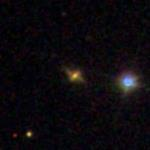

In [ ]:
import random

#random.seed(42)

image_path_list = list(test_dir.glob("*/*.jpg"))

'''
Let's visualise random image
'''
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
original_img = Image.open(random_image_path)
original_img

In [ ]:
!pip install astropy &> /dev/null
!pip install photutils &> /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00


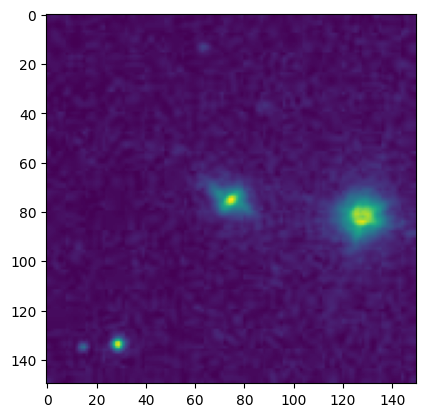

In [ ]:
import matplotlib.pyplot as plt
img = original_img.convert("L")
#img = img[:,:,0] --> For different color channels
img = np.array(img)
img = img.astype("float64")
plt.imshow(img)

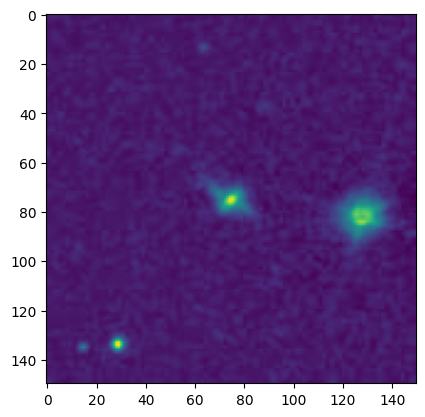

In [ ]:
from photutils.background import Background2D, MedianBackground
import cv2

bkg_estimator = MedianBackground()
bkg = Background2D(img, (10, 10), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)
img -= bkg.background  # subtract the background
plt.imshow(img)

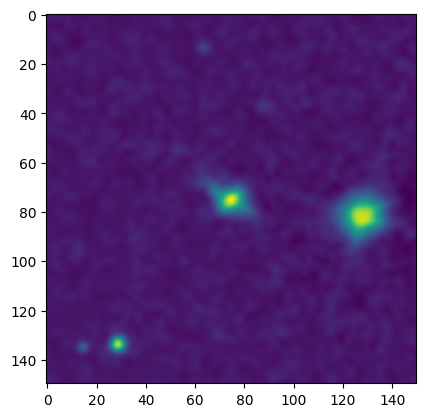

In [ ]:
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
threshold = 1.5 * bkg.background_rms
kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
convolved_data = convolve(img, kernel)
plt.imshow(convolved_data)

In [ ]:
from photutils.segmentation import detect_sources
segment_map = detect_sources(convolved_data, threshold, npixels=10)
print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (150, 150)
nlabels: 23
labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


Text(0.5, 1.0, 'Segmentation Image')

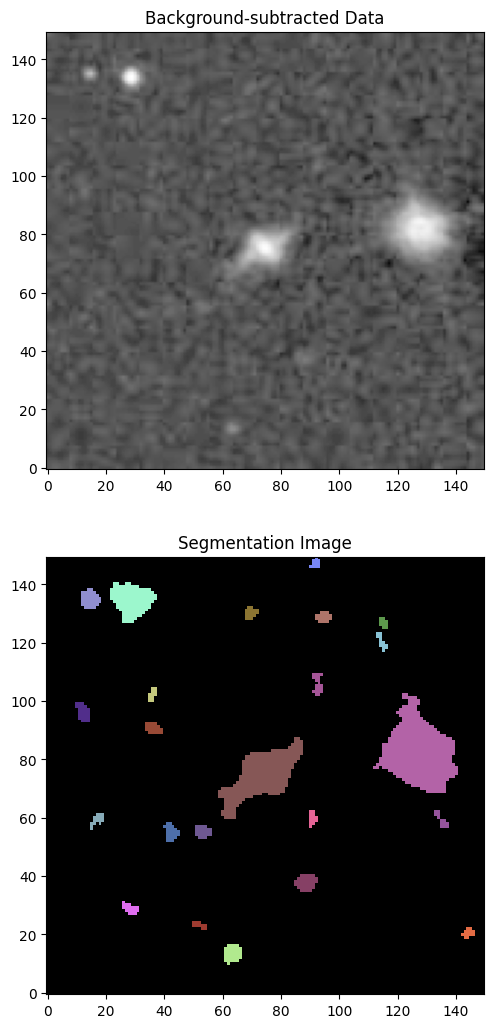

In [ ]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(img, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Background-subtracted Data')
ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap,
           interpolation='nearest')
ax2.set_title('Segmentation Image')

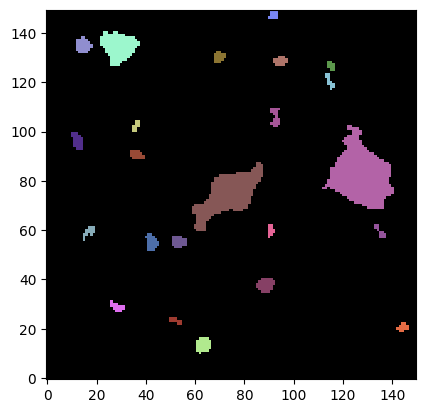

In [ ]:
from photutils.segmentation import deblend_sources
segm_deblend = deblend_sources(convolved_data, segment_map,
                               npixels=10, nlevels=32, contrast=0.001,
                               progress_bar=False)
plt.imshow(segm_deblend, origin='lower', cmap=segment_map.cmap,
           interpolation='nearest')

In [ ]:
print(segm_deblend.areas)
print(np.argmax(segm_deblend.areas))
print(segm_deblend.labels)
print(segm_deblend.labels[np.argmax(segm_deblend.areas)])
print(segm_deblend.get_area(segm_deblend.labels[np.argmax(segm_deblend.areas)]))
print(segm_deblend.max_label)
print(segm_deblend.slices[12])

[ 34  13  10  18  37  27  25  16  13  13 354 528  20  26  11  22  13  10
 146  19  19  37  11]
11
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
12
528
23
(slice(89, 93, None), slice(34, 40, None))


In [ ]:
center = np.array((segm_deblend.data.shape[0] // 2, segm_deblend.data.shape[1] // 2))
candidates = []
for n, slc in enumerate(segm_deblend.slices):
  x, y = slc[0], slc[1]
  slc_center = np.array([(x.start + x.stop)//2, (y.start + y.stop)//2])
  metric = ((slc_center[0] - center[0])**2 + (slc_center[1] - center[1])**2)**(1/2)
  if metric < 0.1*segm_deblend.data.shape[1]:
    candidates.append(n)

[10]


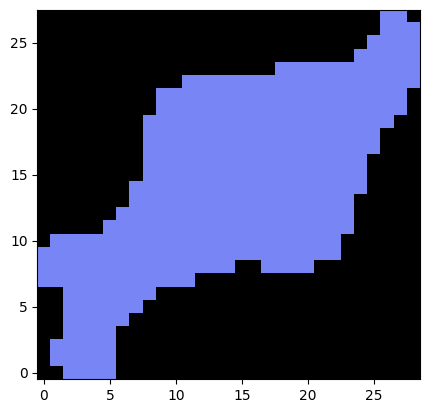

In [ ]:
#slc = segm_deblend.slices[np.argmax(segm_deblend.areas)] --> max not suitable cause it is possible to have another bright source on the image
slc = segm_deblend.slices[candidates[0]]
plt.imshow(segm_deblend[slc], origin='lower', cmap=segment_map.cmap,
           interpolation='nearest')

Text(0.5, 1.0, 'Deblended original img')

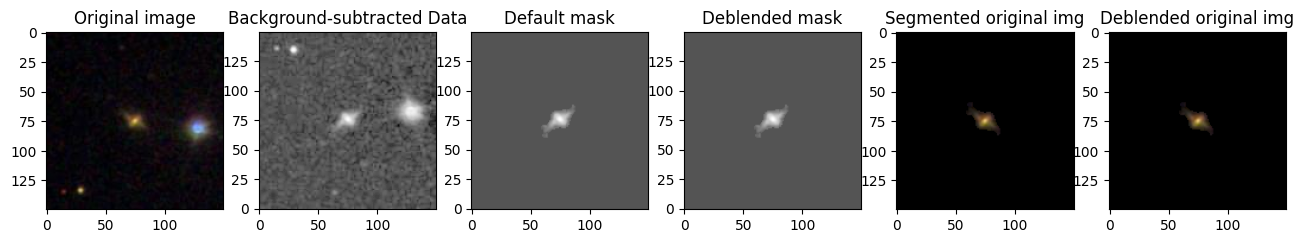

In [ ]:
#mask = np.array(segment_map.data == segment_map.labels[np.argmax(segment_map.areas)])
#debl_mask = np.array(segm_deblend.data == segm_deblend.labels[np.argmax(segm_deblend.areas)])
mask = np.array(segment_map.data == segment_map.labels[candidates[0]])
debl_mask = np.array(segm_deblend.data == segm_deblend.labels[candidates[0]])
#plt.imshow(segm_deblend.data*mask, origin='lower', cmap=segment_map.cmap,
#           interpolation='nearest')

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(16, 16))

ax1.imshow(original_img)
ax1.set_title('Original image')

ax2.imshow(img, origin='lower', cmap='Greys_r', norm=norm)
ax2.set_title('Background-subtracted Data')

ax3.imshow(img*mask, origin='lower', cmap='Greys_r', norm=norm)
ax3.set_title('Default mask')

ax4.imshow(img*debl_mask, origin='lower', cmap='Greys_r', norm=norm)
ax4.set_title('Deblended mask')

ax5.imshow(original_img*np.repeat(mask[:, :, np.newaxis], 3, axis=2))#casting 2D grayscale mask to 3D RGB mask repeating it 3 times, can check like [:,:,0], [:,:,1], [:,:,2]
ax5.set_title('Segmented original img')

ax6.imshow(original_img*np.repeat(debl_mask[:, :, np.newaxis], 3, axis=2))#casting 2D grayscale mask to 3D RGB mask repeating it 3 times, can check like [:,:,0], [:,:,1], [:,:,2]
ax6.set_title('Deblended original img')

### Let's visualise our data

Random image path: /content/drive/MyDrive/nets/polar_rings/test/prg/1237668297670000723.jpg
Image class: prg
Image height: 700
Image width: 700


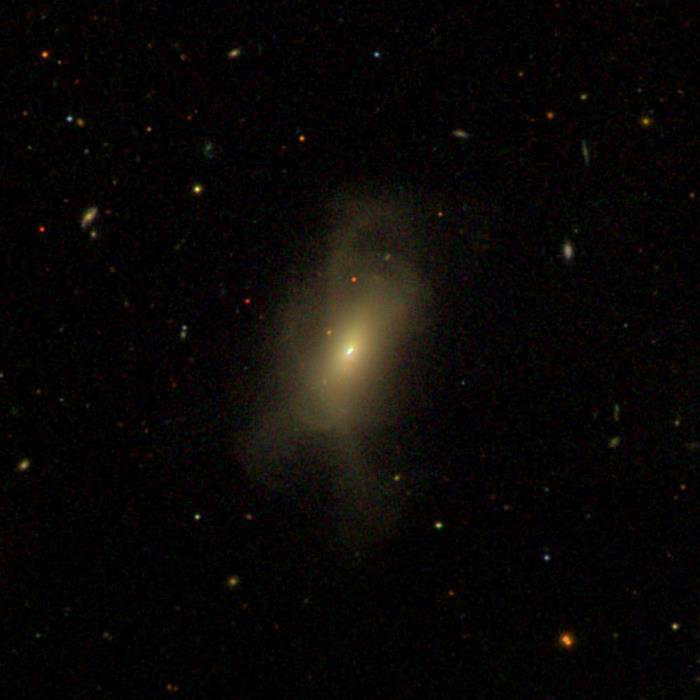

In [ ]:
import random

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

'''
Let's visualise random image
'''
random_image_path = random.choice(image_path_list)

# The image class is the name of the directory where the image is stored
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

### Also let's generate additional prg galaxies using augmentations

In [ ]:
from torchvision import transforms
import matplotlib.pyplot as plt

test_prg_path = test_dir / "prg"
test_prg_list = list(test_prg_path.glob("*"))
print(len(test_prg_list))

transform = transforms.Compose([
  #transforms.Resize(size=(64, 64)),
  transforms.RandomHorizontalFlip(p=0.8), # p = probability of flip, 0.5 = 50% chance
  transforms.RandomVerticalFlip(p=0.8),
  transforms.RandomRotation(degrees=(0, 360))
  #transforms.RandomPerspective(distortion_scale=0.3, p=1.0)
  #transforms.ColorJitter(brightness=(0.5,2),contrast=(1,2),saturation=(0.5,2),hue=(-0.1,0.1))
  #transforms.ColorJitter(brightness=(0.9,1.5),contrast=(1),saturation=(0.9,1.5),hue=(-0.1,0.1)), #previous stable one
  #Lowering variance of parameters leads to minimizing fp, so model gives less other galaxies rpg label
])

'''
Some visualisations

for image_path in train_prg_list:
  with Image.open(image_path) as f:
    fig, ax = plt.subplots(1, 4)
    ax[0].imshow(f)
    ax[0].set_title(f"Original \nSize: {f.size}")
    ax[0].axis("off")

    transformed_image = transform(f)
    ax[1].imshow(transformed_image)
    transformed_image = transform(f)
    ax[2].imshow(transformed_image)
    transformed_image = transform(f)
    ax[3].imshow(transformed_image)
  break
'''

10


'\nSome visualisations\n\nfor image_path in train_prg_list:\n  with Image.open(image_path) as f:\n    fig, ax = plt.subplots(1, 4)\n    ax[0].imshow(f)\n    ax[0].set_title(f"Original \nSize: {f.size}")\n    ax[0].axis("off")\n\n    transformed_image = transform(f)\n    ax[1].imshow(transformed_image)\n    transformed_image = transform(f)\n    ax[2].imshow(transformed_image)\n    transformed_image = transform(f)\n    ax[3].imshow(transformed_image)\n  break\n'

In [ ]:
train_prg_path = train_dir / "prg"
train_prg_list = list(train_prg_path.glob("*"))
len(train_prg_list)

0

In [ ]:
NUM_OF_AUGM = 8

for image_path in test_prg_list:
  with Image.open(image_path) as f:
    for i in range(NUM_OF_AUGM):
      transformed_img = transform(f)
      #fig, ax = plt.subplots(1, 6)
      #ax[i+1].imshow(transformed_img)
      #print(str(image_path)[:50] + f"aug{i+1}_" + str(image_path)[50:])
      transformed_img.save(str(image_path)[:81] + f"aug{i+1}_" + str(image_path)[81:])
    #ax[0].imshow(f)
  #break

## Creating dataloaders

In [ ]:
from torch.utils.data import DataLoader
from typing import Tuple, List, Dict

In [ ]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  import os
  """
  Finds the class folder names in a target directory.

  Assumes target directory is in standard image classification format.

  Args:
    directory (str): target directory to load classnames from.

  Returns:
    Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

  """
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx

### Creating custom Dataset

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(self, targ_dir: str, transform=None) -> None:
    self.paths = list(Path(targ_dir).glob("*/*"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
    '''
    Opens an image via a path and returns it.
    '''
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    '''
    Returns the total number of samples.
    '''
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[Image.Image, int]:#or Tuple[torch.Tensor, int] with appropriate transform
    '''
    Returns one sample of data, data and label (X, y).
    '''
    img = self.load_image(index)
    class_name  = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

### Let's define transform for our data.

In [ ]:
!pip install astropy &> /dev/null
!pip install photutils &> /dev/null

In [ ]:
from photutils.background import Background2D, MedianBackground
import cv2
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources

class CreateSegmap(object):
  def __init__(self, blended:bool=False):
    self.blended = blended

  def __call__(self, original_img):
    #img = np.array(original_img.convert("L")).astype("float64")
    img = original_img.convert("L")
    img = np.array(img)
    img = img.astype("float64")

    #removing background noise
    bkg_estimator = MedianBackground()
    bkg = Background2D(img, (40, 40), filter_size=(7, 7), #The box size should generally be larger than the typical size of sources
                                                          #in the image, but small enough to encapsulate any background variations. For best results, the box size should also
                                                          # be chosen so that the data are covered by an integer number of boxes in both dimensions.
                      bkg_estimator=bkg_estimator, exclude_percentile=20.0)
    img -= bkg.background  # subtract the background

    #Convolvong with 2D kernel
    threshold = 0.5 * bkg.background_rms
    kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
    convolved_data = convolve(img, kernel)

    #Creating segmap
    segment_map = detect_sources(convolved_data, threshold, npixels=10)

    #Deblending sources from segmap if deblend==True
    if not self.blended:
      candidates = self.find_candidates(segment_map)
      if len(candidates) != 0:
        mask = np.array(segment_map.data == segment_map.labels[candidates[0]])
      else:
        mask = np.ones((segment_map.data.shape[0], segment_map.data.shape[1]))
    else:
      segm_deblend = deblend_sources(convolved_data, segment_map,
                                npixels=10, nlevels=32, contrast=0.001,
                                progress_bar=False)
      candidates = self.find_candidates(segm_deblend)
      if len(candidates) != 0:
        mask = np.array(segm_deblend.data == segm_deblend.labels[candidates[0]])
      else:
        mask = np.ones((segm_deblend.data.shape[0], segm_deblend.data.shape[1]))

    segmented_image = original_img*np.repeat(mask[:, :, np.newaxis], 3, axis=2)#casting 2D grayscale mask to 3D RGB mask repeating it 3 times, can check like [:,:,0], [:,:,1], [:,:,2]
    return Image.fromarray(np.uint8(segmented_image))

  def find_candidates(self, map):
    center = np.array((map.data.shape[0] // 2, map.data.shape[1] // 2))
    candidates = []
    for n, slc in enumerate(map.slices):
      x, y = slc[0], slc[1]
      slc_center = np.array([(x.start + x.stop)//2, (y.start + y.stop)//2])
      metric = ((slc_center[0] - center[0])**2 + (slc_center[1] - center[1])**2)**(1/2)
      if metric < 0.05*map.data.shape[1]:
        candidates.append(n)

    return candidates

  def __repr__(self):
    return "Creates segmentation map, cropping central source"

In [ ]:
'''
For this purpose we should know the minimal size of images provided to rescale them all to it.
'''
image_path_list = list(image_path.glob("*/*/*.jpg"))
min_size = 1000
for image_path in image_path_list:
  img = Image.open(image_path)
  if img.height < min_size:
    min_size = img.height
  #if img.height != img.width: print("Not a square!") all the images are squares
print(f"Minimal size is {min_size}")

In [ ]:
from torchvision import transforms

#So, cause minimal size is 80x80, we should resize all the images to that size

augment_transforms = transforms.Compose([
  #CreateSegmap(blended=False),
  transforms.Resize((80, 80)),#More resolution is not suitable cause minimal size on train set is 80x80
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomVerticalFlip(p=0.5),
  transforms.ToTensor()
])

general_transforms = transforms.Compose([
    CreateSegmap(blended=False), #Segmantation stabilising training process and loss function steps, also helps in generalisation?
    transforms.Resize((80, 80), interpolation=transforms.InterpolationMode.BICUBIC),#More resolution is not suitable cause minimal size on train set is 80x80
    transforms.ToTensor(),
    #transforms.Grayscale()
])

### Custom Transform visualisation

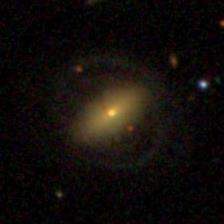

In [ ]:
import random

#random.seed(42)

image_path_list = list(test_dir.glob("*/*.jpg"))

'''
Let's visualise random image
'''
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
original_img = Image.open(random_image_path)
original_img

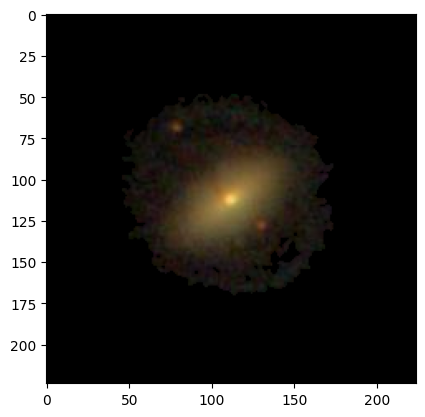

In [ ]:
import matplotlib.pyplot as plt
segmap = CreateSegmap(blended=False)
plt.imshow(segmap(original_img))

### Creating Datasets from our data

In [ ]:
#train_data = CustomDataset(targ_dir=train_dir, transform=augment_transforms)
train_data = CustomDataset(targ_dir=train_dir, transform=general_transforms)
valid_data = CustomDataset(targ_dir=valid_dir, transform=general_transforms)
test_data = CustomDataset(targ_dir=test_dir, transform=general_transforms)

In [ ]:
len(train_data),len(valid_data), len(test_data), train_data.classes, valid_data.classes, test_data.classes, train_data.class_to_idx, len(train_data) + len(valid_data) + len(test_data)

(1465,
 12,
 183,
 ['others', 'prg'],
 ['others', 'prg'],
 ['others', 'prg'],
 {'others': 0, 'prg': 1},
 1660)

### Creating Dataloaders

In [ ]:
import os

BATCH_SIZE = 16

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=torch.cuda.device_count()*2,
                              shuffle=True,
                              pin_memory=True) #should always be True for training on GPU, speeds up the transfer to it

valid_dataloader = DataLoader(dataset=valid_data,
                              batch_size=1,
                              num_workers=torch.cuda.device_count()*2,
                              shuffle=False,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=1,
                            num_workers=torch.cuda.device_count()*2,
                            shuffle=False,
                            pin_memory=True)


In [ ]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 80, 80]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


### Visualising tensors from dataset

In [ ]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

  import matplotlib.pyplot as plt

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)
  plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
    targ_image_adjust = targ_image.permute(1, 2, 0)
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

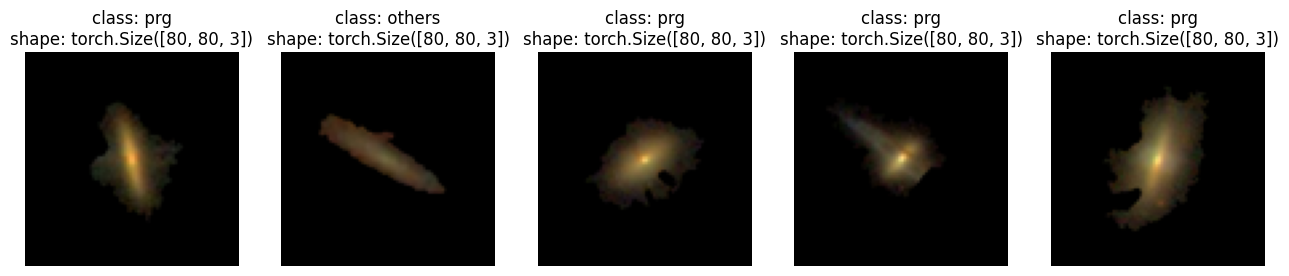

In [ ]:
display_random_images(test_data, n=5, classes=test_data.classes, seed=None)

## Part 2 - Building the CNN

In [ ]:
class DoubleConv(nn.Module):
  '''
  Main bulding block of the net. Consists of two consecutive convolutional
  2D layers with ReLU activation and dp% dropout.
  '''
  def __init__(self, in_channels, out_channels, dp):
    super().__init__()
    self.conv = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Dropout(p=dp),
      nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),#, bias=False), -> if Normalisation exists
      nn.ReLU(),
      nn.Dropout(p=dp),
      nn.MaxPool2d(kernel_size = 2, stride = 2) #The pooling layer summarises the features
                                                #present in a region of the feature map generated by a
                                                #convolution layer. So, further operations are performed on
                                                #summarised features instead of precisely positioned features generated by the
                                                #convolution layer. This makes the model more robust to
                                                #variations in the position of the features in the input image.
    )

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.conv(x)

class PRGClassificator(nn.Module):
  def __init__(self, input_features: int, output_features: int, hidden_units: int, num_blocks: int, dp: float):
    super().__init__()
    self.forward_path_list = nn.ModuleList()

    for block in range(num_blocks):
      self.forward_path_list.append(DoubleConv(input_features, hidden_units, dp))
      input_features = hidden_units

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(int(hidden_units*((80*(1/2**num_blocks))**2)), output_features),#As image size is decreased to NxN
                                                                        #due to num_blocks pooling layers,
                                                                        #where N = 80*(1/2)**(num_blocks)
      nn.Sigmoid()
    )

  def forward(self, x):
    for block in self.forward_path_list:
      x = block(x)
    return self.classifier(x)

### Model analytics

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
#Model initialisation
torch.manual_seed(42)
model = PRGClassificator(input_features=3, # number of color channels
                  output_features=len(train_data.classes),
                  hidden_units=10,
                  num_blocks = 1).to(device)

summary(model, input_size=[1, 3, 80, 80]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
PRGClassificator                         [1, 2]                    --
├─ModuleList: 1-1                        --                        --
│    └─DoubleConv: 2-1                   [1, 10, 40, 40]           --
│    │    └─Sequential: 3-1              [1, 10, 40, 40]           1,190
├─Sequential: 1-2                        [1, 2]                    --
│    └─Flatten: 2-2                      [1, 16000]                --
│    └─Linear: 2-3                       [1, 2]                    32,002
Total params: 33,192
Trainable params: 33,192
Non-trainable params: 0
Total mult-adds (M): 7.65
Input size (MB): 0.08
Forward/backward pass size (MB): 1.02
Params size (MB): 0.13
Estimated Total Size (MB): 1.23

## Part 3 - Training the CNN

### Defining train_step function

In [ ]:
def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer):

  #import time

  model.train()
  train_loss, train_acc = 0, 0
  #start_time = 0
  for X, y in dataloader:
    X, y = X.to(device), y.to(device)

    # FORWARD PASS
    '''
    For multiclass

    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)
    '''

    # FORWARD PASS
    y_pred = model(X).view(y.shape)
    loss = loss_fn(y_pred, y.float())
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = y_pred.round()
    train_acc += ((y_pred_class == y).sum().item()/len(y_pred_class))

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

### Defining valid_step function

In [ ]:
def valid_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  model.eval()
  valid_loss, valid_acc = 0, 0

  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      '''
      Multiclass
      # FORWARD PASS
      valid_pred_logits = model(X)
      loss = loss_fn(valid_pred_logits, y)
      valid_loss += loss.item()
      valid_pred_labels = valid_pred_logits.argmax(dim=1)
      valid_acc += ((valid_pred_labels == y).sum().item()/len(valid_pred_labels))
      '''
      # FORWARD PASS
      valid_pred_logits = model(X).view(y.shape)
      loss = loss_fn(valid_pred_logits, y.float())
      valid_loss += loss.item()
      valid_pred_class = valid_pred_logits.round()
      valid_acc += ((valid_pred_class == y).sum().item()/len(valid_pred_class))

  # Adjust metrics to get average loss and accuracy per batch
  valid_loss = valid_loss / len(dataloader)
  valid_acc = valid_acc / len(dataloader)
  return valid_loss, valid_acc

### Defining whole training function

In [ ]:
def train(model_name: str,
          model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          valid_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 20):

  min_val_acc = 0.6
  torch.manual_seed(42)

  from tqdm.auto import tqdm

  results = {"model_name": [],
    "train_loss": [],
    "train_acc": [],
    "valid_loss": [],
    "valid_acc": []
  }
  print(model_name)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer)
    valid_loss, valid_acc = valid_step(model=model,
        dataloader=valid_dataloader,
        loss_fn=loss_fn)

    scheduler.step(valid_loss)

    print(
      f"Epoch: {epoch+1} | "
      f"train_loss: {train_loss:.4f} | "
      f"train_acc: {train_acc:.4f} | "
      f"valid_loss: {valid_loss:.4f} | "
      f"valid_acc: {valid_acc:.4f}"
    )

    if valid_acc >= min_val_acc:
      torch.save(model.state_dict(), model_name)
      print(f"Saved accuracy is {valid_acc}")
      min_val_acc = valid_acc

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["valid_loss"].append(valid_loss)
    results["valid_acc"].append(valid_acc)

  results["model_name"].append(model_name)
  return results

### Training Loop

In [ ]:
num_blocks = [1]#[1, 2, 3]#4 blocks tested, stable 50%
hidden_units = [10]#[10, 50, 100]#[10, 50, 100, 200, 400]
learning_rates = [1e-4]#[1e-3, 1e-4]#[1e-3, 5e-4, 1e-4, 5e-5]
dropouts = [0.5]#[0.1, 0.2]
hyperparams_grid = []
for block in num_blocks:
  for hu in hidden_units:
    for lr in learning_rates:
      for dropout in dropouts:
        hyperparams_grid.append((block, hu, lr, dropout))

In [ ]:
'''
CHECK THESE

For ['model_hu10_blocks1_lr0.001'] best valid_loss is 0.6476480677723885 for acc 0.75
For ['model_hu10_blocks1_lr0.0005'] best valid_loss is 0.5645014506648295 for acc 0.7     -
For ['model_hu50_blocks1_lr0.001'] best valid_loss is 0.6493203544799598 for acc 0.75
For ['model_hu100_blocks1_lr0.001'] best valid_loss is 0.6723072484135628 for acc 0.75
For ['model_hu100_blocks1_lr0.0005'] best valid_loss is 0.4840030772611385 for acc 0.7    -
For ['model_hu200_blocks1_lr0.0005'] best valid_loss is 0.667924758605659 for acc 0.75
For ['model_hu200_blocks1_lr0.0001'] best valid_loss is 0.6068458913825452 for acc 0.7
For ['model_hu200_blocks1_lr5e-05'] best valid_loss is 0.6206109322607517 for acc 0.75    -
For ['model_hu400_blocks1_lr0.0005'] best valid_loss is 0.6931484043598175 for acc 0.7    -
For ['model_hu10_blocks2_lr0.0005'] best valid_loss is 0.6179103586357086 for acc 0.7     -
For ['model_hu200_blocks2_lr0.0001'] best valid_loss is 0.6879961729049683 for acc 0.75
For ['model_hu400_blocks2_lr0.0001'] best valid_loss is 0.6551367722451686 for acc 0.7    -
For ['model_hu100_blocks3_lr0.0005'] best valid_loss is 0.6941133096814156 for acc 0.75

BEST: model_hu10_blocks1_lr0.0001_dp0.25, model_hu50_blocks1_lr0.0001_dp0.2
'''

hyperparams_grid = [(1, 50, 0.0001, 0.1)]#[(1, 50, 0.0001, 0.2)]

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 100

grid_results = []
for params in hyperparams_grid:
  model_results = {}
  num_blocks = params[0]
  hidden_units = params[1]
  lr = params[2]
  dropout = params[3]
  #Model initialisation
  model = PRGClassificator(input_features=3, # number of color channels
                          hidden_units=hidden_units,
                          output_features=1,#len(train_data.classes),
                          num_blocks = num_blocks,
                          dp = dropout).to(device)

  # Choosing Loss function and optimizer
  #loss_fn = nn.CrossEntropyLoss()
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=1e-3)#wd == L2 regularization

  # Training model
  model_results = train(model_name = f"model_hu{hidden_units}_blocks{num_blocks}_lr{lr}_dp{dropout}",
                        model=model,
                        train_dataloader=train_dataloader,
                        valid_dataloader=valid_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
  grid_results.append(model_results)

model_hu10_blocks1_lr0.0001_dp0.5


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6971 | train_acc: 0.5018 | valid_loss: 0.6929 | valid_acc: 0.5000
Epoch: 2 | train_loss: 0.6907 | train_acc: 0.5194 | valid_loss: 0.6919 | valid_acc: 0.5000
Epoch: 3 | train_loss: 0.6859 | train_acc: 0.5441 | valid_loss: 0.6893 | valid_acc: 0.5833
Epoch: 4 | train_loss: 0.6729 | train_acc: 0.5771 | valid_loss: 0.6795 | valid_acc: 0.6667
Saved accuracy is 0.6666666666666666
Epoch: 5 | train_loss: 0.6500 | train_acc: 0.6501 | valid_loss: 0.6700 | valid_acc: 0.5000
Epoch: 6 | train_loss: 0.6096 | train_acc: 0.7306 | valid_loss: 0.6641 | valid_acc: 0.6667
Saved accuracy is 0.6666666666666666
Epoch: 7 | train_loss: 0.5668 | train_acc: 0.7632 | valid_loss: 0.6574 | valid_acc: 0.6667
Saved accuracy is 0.6666666666666666
Epoch: 8 | train_loss: 0.5198 | train_acc: 0.7939 | valid_loss: 0.6606 | valid_acc: 0.6667
Saved accuracy is 0.6666666666666666
Epoch: 9 | train_loss: 0.4794 | train_acc: 0.8106 | valid_loss: 0.6692 | valid_acc: 0.6667
Saved accuracy is 0.6666666666666

In [ ]:
for result in grid_results:
  if max(result['valid_acc']) >= 0.7:
    print(f"For {result['model_name']} best valid_loss is {min(result['valid_loss'])} for acc {max(result['valid_acc'])}")

For ['model_hu10_blocks1_lr0.001'] best valid_loss is 0.6476480677723885 for acc 0.75
For ['model_hu10_blocks1_lr0.0005'] best valid_loss is 0.5645014506648295 for acc 0.7
For ['model_hu50_blocks1_lr0.001'] best valid_loss is 0.6493203544799598 for acc 0.75
For ['model_hu100_blocks1_lr0.001'] best valid_loss is 0.6723072484135628 for acc 0.75
For ['model_hu100_blocks1_lr0.0005'] best valid_loss is 0.4840030772611385 for acc 0.7
For ['model_hu200_blocks1_lr0.0005'] best valid_loss is 0.667924758605659 for acc 0.75
For ['model_hu200_blocks1_lr0.0001'] best valid_loss is 0.6068458913825452 for acc 0.7
For ['model_hu200_blocks1_lr5e-05'] best valid_loss is 0.6206109322607517 for acc 0.75
For ['model_hu400_blocks1_lr0.0005'] best valid_loss is 0.6931484043598175 for acc 0.7
For ['model_hu10_blocks2_lr0.0005'] best valid_loss is 0.6179103586357086 for acc 0.7
For ['model_hu200_blocks2_lr0.0001'] best valid_loss is 0.6879961729049683 for acc 0.75
For ['model_hu400_blocks2_lr0.0001'] best vali

### Analysing results

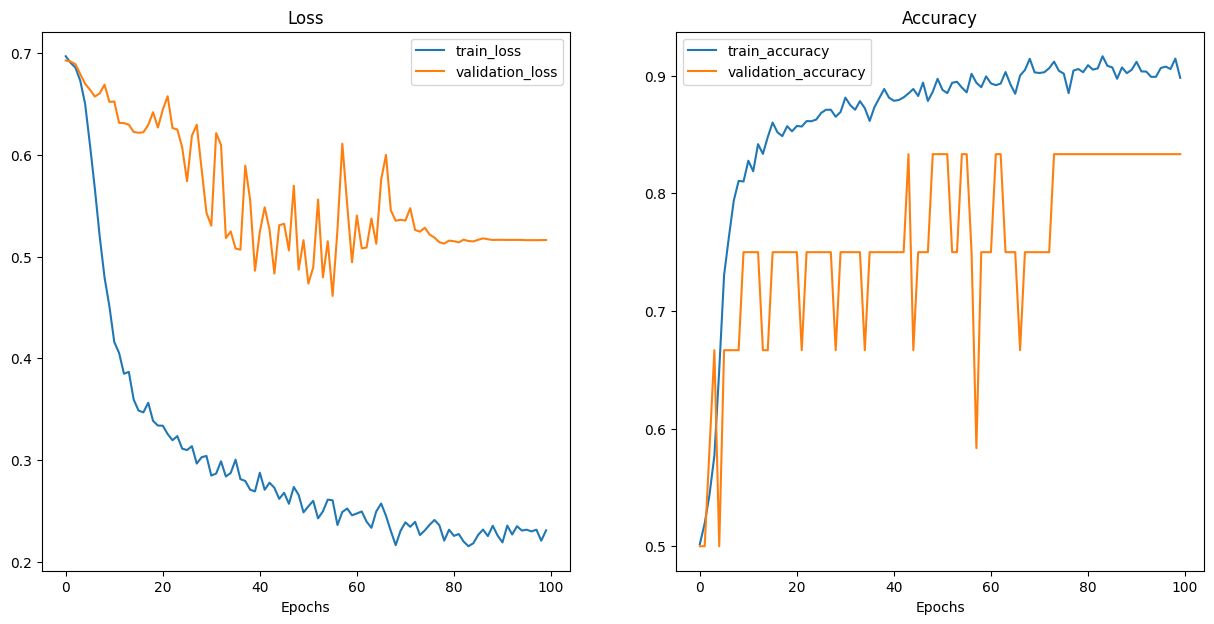

In [ ]:
import matplotlib.pyplot as plt

loss = model_results['train_loss']
valid_loss = model_results['valid_loss']
accuracy = model_results['train_acc']
valid_accuracy = model_results['valid_acc']
epochs = range(len(model_results['train_loss']))

# Setup a plot
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, valid_loss, label='validation_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='train_accuracy')
plt.plot(epochs, valid_accuracy, label='validation_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

In [ ]:
print(loss[90:], valid_loss[90:])
print(accuracy[90:], valid_accuracy[90:])

[3.338547854524529e-06, 3.0323780977284255e-06, 2.9099535480322145e-06, 2.797323372980659e-06, 2.530350545431894e-06, 2.4354382360205907e-06, 2.282383430521736e-06, 2.2018297231320878e-06, 2.119800171330151e-06, 2.066721376906925e-06] [2.9974679645685043e-06, 2.7768650933124306e-06, 2.68133294322763e-06, 2.5689462703759602e-06, 2.5462611695305426e-06, 2.251193961347716e-06, 2.164213775299316e-06, 2.054235071446446e-06, 2.03734243979316e-06, 1.8328220317765349e-06]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## Part 4 - Making predictions on test set

In [ ]:
test_loss, test_acc = 0, 0

model = PRGClassificator(input_features=3, # number of color channels
                          hidden_units=hidden_units,
                          output_features=1,
                          num_blocks = 1,
                          dp = 0.5).to(device)
model.load_state_dict(torch.load("model_hu10_blocks1_lr0.0001_dp0.5"))#, map_location=torch.device('cpu')))
model.eval()
test_labels, pred_labels = [], []
with torch.inference_mode():
  fp = 0
  for batch, (X, y) in enumerate(test_dataloader):
    X, y = X.to(device), y.to(device)

    test_pred_logits = model(X)
    loss = loss_fn(test_pred_logits.view(y.shape), y.float())
    test_loss += loss.item()

    test_pred_labels = test_pred_logits.round()
    if test_pred_labels != y:
      #print(f"Model named {test_data.classes[y]} galaxy as {test_data.classes[test_pred_labels]} galaxy!")
      if y == 0:
        fp += 1
        print(f"Galaxy classified as prg is {test_data.paths[batch]}")
    test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    test_labels.append(y.item())
    pred_labels.append(test_pred_labels.item())

# Adjust metrics to get average loss and accuracy per batch
test_loss = test_loss / len(test_dataloader)
test_acc = test_acc / len(test_dataloader)

print(test_loss, test_acc, fp)

Galaxy classified as prg is /content/augmented_test/others/1237648675606167707.jpeg
Galaxy classified as prg is /content/augmented_test/others/1237648675069953008.jpeg
Galaxy classified as prg is /content/augmented_test/others/1237648675069952145.jpeg
Galaxy classified as prg is /content/augmented_test/others/1237648673997128266.jpeg
Galaxy classified as prg is /content/augmented_test/others/1237648673997062491.jpeg
Galaxy classified as prg is /content/augmented_test/others/1237648702978654353.jpeg
Galaxy classified as prg is /content/augmented_test/others/1237648673996997073.jpeg
0.3233194430804261 0.8907103825136612 7


In [ ]:
!pip install torchmetrics &> /dev/null
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

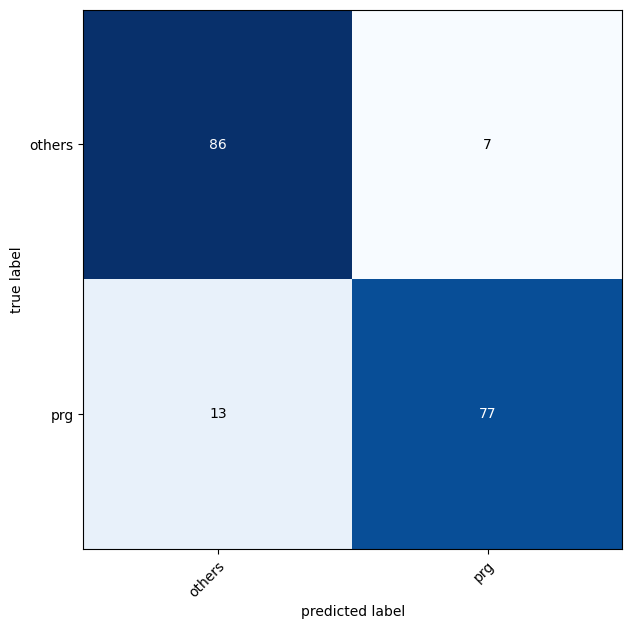

In [ ]:
confmat = ConfusionMatrix(num_classes=len(test_data.classes), task='multiclass')
confmat_tensor = confmat(preds = torch.Tensor(pred_labels), target = torch.Tensor(test_labels))

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=list(test_data.class_to_idx.keys()),
    figsize=(10, 7)
)

#plt.savefig("conf_matrix.png", dpi=300)

# IN SEARCH OF PRG in 317018 images

# Andr model

In [ ]:
import numpy as np
from keras.preprocessing import image
from keras.applications import VGG16  # Replace with your desired pre-trained model
from keras.applications.vgg16 import preprocess_input, decode_predictions  # Adjust imports based on the model
from PIL import Image
import os
from tqdm import tqdm
from pathlib import Path
import tensorflow as tf

In [ ]:
paths = list(Path("/content/317018/317018").glob("*"))
len(paths)

312984

In [ ]:
import PIL
from PIL import Image

n = 0
for path in paths:
  try:
    img = Image.open(path)
    tf.io.encode_jpeg(img)
  except:
    os.remove(path)
    #print(f"Deleted file {path}")
    n+=1
print(f"Total {n} files deleted")

Total 4434 files deleted


In [ ]:
paths = list(Path("/content/317018/317018").glob("*"))
len(paths)

308550

In [ ]:
from keras.preprocessing import image
import pandas as pd
import sys

def predict_folder(image_paths, model, batch_size):
  # Define batch size and number of workers
  num_workers = 2

  # Creating dataset
  with tf.device('CPU'):
    test_ds = tf.keras.utils.image_dataset_from_directory(
                                          image_paths,
                                          shuffle=False,
                                          image_size=(224, 224),
                                          batch_size=batch_size,
                                          cache=False
                                          )

    files_paths = test_ds.file_paths
    test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.float32), y)) #converting to float
    scaling_layer = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1) # defining rescaling to [-1, 1]
    test_ds = test_ds.map(lambda x, y: (scaling_layer(x), y)) # actually rescaling

  all_predictions = pd.DataFrame(columns=['name', 'score'])
  _ = 0
  for x, Y in test_ds:
    if _+batch_size > 308550:
      pred = model.predict(x)
      temp = pd.DataFrame(zip(files_paths[_:_+len(pred) - 1], pred), columns=['name', 'score'])
      all_predictions = pd.concat([all_predictions, temp])
      break
    pred = model.predict(x)
    temp = pd.DataFrame(zip(files_paths[_:_+batch_size], pred), columns=['name', 'score'])
    _ += batch_size
    all_predictions = pd.concat([all_predictions, temp])
    print(sys.getsizeof(all_predictions)/1024/1024)
    print(_/batch_size)

  return all_predictions

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/nets/prg_classification/trained_models/models_andr_old")

ValueError: File format not supported: filepath=/content/drive/MyDrive/nets/prg_classification/trained_models/models_andr_old. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(/content/drive/MyDrive/nets/prg_classification/trained_models/models_andr_old, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [ ]:
all_predictions = predict_folder("/content/317018/", model, batch_size = 128)
all_predictions.to_csv('andr_results.csv')

TypeError: Unknown keywords argument(s): ('cache',)

In [ ]:
all_predictions

,name,score


# Mine model

In [ ]:
from pathlib import Path
import PIL
from PIL import Image
from torch.utils.data import DataLoader
from typing import Tuple, List, Dict
from torch.utils.data import Dataset
import pandas as pd

# Setup path to data folder
test_dir = Path("/content/317018/317018")#Path("/content/test_prg/")
if test_dir.is_dir():
    print(f"{test_dir} directory exists.")

/content/317018/317018 directory exists.


In [ ]:
class TestDataset(Dataset):
  def __init__(self, targ_dir: str, transform=None) -> None:
    self.paths = list(Path(targ_dir).glob("*"))
    self.transform = transform

  def load_image(self, index: int) -> Image.Image:
    '''
    Opens an image via a path and returns it.
    '''
    image_path = self.paths[index]
    try:
      return Image.open(image_path), self.paths[index]
    except:
      return torch.zeros(3, 80, 80), self.paths[index]#Image.new('RGB', (80, 80)), self.paths[index]

  def __len__(self) -> int:
    '''
    Returns the total number of samples.
    '''
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[Image.Image, int]:#or Tuple[torch.Tensor, int] with appropriate transform
    '''
    Returns one sample of data, data and label (X, y).
    '''
    img, path = self.load_image(index)
    if type(img) == PIL.JpegImagePlugin.JpegImageFile:
      return self.transform(img), path.__str__()
    else:
      return img, path.__str__()

In [ ]:
!pip install astropy &> /dev/null
!pip install photutils &> /dev/null

from photutils.background import Background2D, MedianBackground
import cv2
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources

class CreateSegmap(object):
  def __init__(self, blended:bool=False):
    self.blended = blended

  def __call__(self, original_img):
    #img = np.array(original_img.convert("L")).astype("float64")
    img = original_img.convert("L")
    img = np.array(img)
    img = img.astype("float64")

    #removing background noise
    bkg_estimator = MedianBackground()
    bkg = Background2D(img, (40, 40), filter_size=(7, 7), #The box size should generally be larger than the typical size of sources
                                                          #in the image, but small enough to encapsulate any background variations. For best results, the box size should also
                                                          # be chosen so that the data are covered by an integer number of boxes in both dimensions.
                      bkg_estimator=bkg_estimator, exclude_percentile=20.0)
    img -= bkg.background  # subtract the background

    #Convolvong with 2D kernel
    threshold = 0.5 * bkg.background_rms
    kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
    convolved_data = convolve(img, kernel)

    #Creating segmap
    segment_map = detect_sources(convolved_data, threshold, npixels=10)

    #Deblending sources from segmap if deblend==True --> see segmap for training
    if segment_map == None:
      mask = np.ones((original_img.size[0], original_img.size[1]))
    else:
      try:
        candidates = self.find_candidates(segment_map)
      except:
        candidates = []

      if len(candidates) != 0:
        mask = np.array(segment_map.data == segment_map.labels[candidates[0]])
      else:
        mask = np.ones((segment_map.data.shape[0], segment_map.data.shape[1]))

    segmented_image = original_img*np.repeat(mask[:, :, np.newaxis], 3, axis=2)#casting 2D grayscale mask to 3D RGB mask repeating it 3 times, can check like [:,:,0], [:,:,1], [:,:,2]
    return Image.fromarray(np.uint8(segmented_image))

  def find_candidates(self, map):
    center = np.array((map.data.shape[0] // 2, map.data.shape[1] // 2))
    candidates = []
    for n, slc in enumerate(map.slices):
      x, y = slc[0], slc[1]
      slc_center = np.array([(x.start + x.stop)//2, (y.start + y.stop)//2])
      metric = ((slc_center[0] - center[0])**2 + (slc_center[1] - center[1])**2)**(1/2)
      if metric < 0.05*map.data.shape[1]:
        candidates.append(n)

    return candidates

  def __repr__(self):
    return "Creates segmentation map, cropping central source"


In [ ]:
from torchvision import transforms

general_transforms = transforms.Compose([
    CreateSegmap(blended=False),
    transforms.Resize((80, 80), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
])

test_data = TestDataset(targ_dir=test_dir, transform=general_transforms)
len(test_data)

9

In [ ]:
BATCH_SIZE = 1

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=torch.cuda.device_count()*2,
                              shuffle=False,
                              pin_memory=True)

In [ ]:
model = PRGClassificator(input_features=3,
                          hidden_units=10,
                          output_features=1,
                          num_blocks = 1,
                          dp = 0.5).to(device)
#model.load_state_dict(torch.load("model_hu10_blocks1_lr0.0001_dp0.5_with_segmentation"))
model.load_state_dict(torch.load(("drive/MyDrive/nets/prg_classification/trained_models/model_hu10_blocks1_lr0.0001_dp0.5_with_segmentation"), map_location=torch.device('cpu')))
model.eval()

results = pd.DataFrame(columns=['name', 'score'])
with torch.inference_mode():
  n = 0
  for X, paths in test_dataloader:
    #if n == 106: break
    X = X.to(device)

    test_scores = model(X)
    temp = pd.DataFrame(zip(paths, test_scores.view(test_scores.shape[0]).numpy()), columns=['name', 'score'])
    results = pd.concat([results, temp])
    #n+=1

In [ ]:
results

,name,score
0,/content/test_prg/PRG5.jpeg,0.986683
0,/content/test_prg/PRG7.jpeg,0.788601
0,/content/test_prg/PRG2.jpeg,0.996931
0,/content/test_prg/.ipynb_checkpoints,0.834103
0,/content/test_prg/PRG6.jpeg,0.994540
0,/content/test_prg/PRG4.jpeg,0.848842
0,/content/test_prg/PRG1.jpeg,0.520814
0,/content/test_prg/PRG3.jpeg,0.992909
0,/content/test_prg/PRG8.jpeg,0.091188


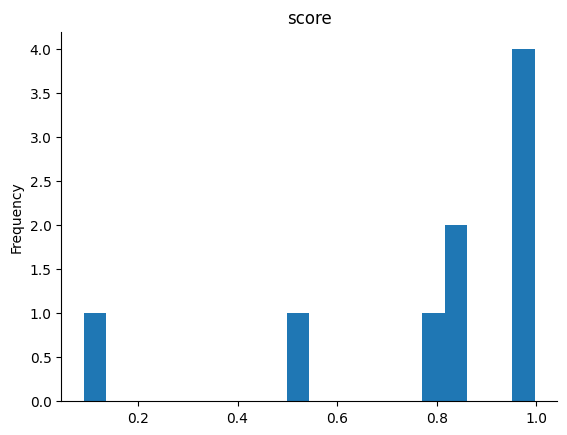

In [ ]:
from matplotlib import pyplot as plt
results['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
results['name']

0      /content/317018/317018/1237661970104451250.jpeg
1      /content/317018/317018/1237656494576828689.jpeg
2      /content/317018/317018/1237671992951374090.jpeg
3      /content/317018/317018/1237671992412078287.jpeg
4      /content/317018/317018/1237661465456673094.jpeg
                            ...                       
147    /content/317018/317018/1237668292833640795.jpeg
148    /content/317018/317018/1237664132094951427.jpeg
149    /content/317018/317018/1237665373867409601.jpeg
150    /content/317018/317018/1237660963479748892.jpeg
151    /content/317018/317018/1237659329782087736.jpeg
Name: name, Length: 312984, dtype: object

In [ ]:
results.to_csv('results.csv')

## Results Comparison

In [3]:
import pandas as pd

In [70]:
data_ol = pd.read_csv("/content/drive/MyDrive/nets/prg_classification/results/prediction_score_ol.csv")
data_dan = pd.read_csv("/content/drive/MyDrive/nets/prg_classification/results/predictions_score_dan.csv")
data_andr = pd.read_csv("/content/drive/MyDrive/nets/prg_classification/results/andr_results_last.csv")
data_ol = data_ol[data_ol['score'] > 0.5].reset_index().drop('index', axis=1).drop('Unnamed: 0', axis=1)
data_ol['name'] = data_ol['name'].apply(lambda x: x.split('/')[4])
data_ol = data_ol.rename(columns={"name": "file_name", "score": "score"})

data_andr_f = pd.DataFrame(columns=['file_name', 'score'])
data_andr_f['file_name'] = data_andr['1'].apply(lambda x: x.split()).explode().apply(lambda x: x[1:-1]).apply(lambda x: x[1:-1] if x[0] == "'" else x).apply(lambda x: x[:-1] if x[-1] == "'" else x).apply(lambda x: x.split('/')[2]).reset_index().drop('index', axis=1)
data_andr_f['score'] = data_andr['0'].apply(lambda x: x.split()).explode().apply(lambda x: x[1:-1])[data_andr['0'].apply(lambda x: x.split()).explode().apply(lambda x: x[1:-1]).apply(lambda x: True if len(x) != 0 else False)].apply(lambda x: x[1:] if x[0] == '[' else x).apply(lambda x: x[:-2] if x[-1] == ']' else x).apply(lambda x: float(x)).reset_index().drop('index', axis=1)
data_andr_f['score'] = data_andr_f['score'] + 0.1502
data_andr = data_andr_f[data_andr_f['score'] > 0.5].reset_index().drop('index', axis=1)

In [73]:
result_df_temp = pd.merge(data_ol, data_dan, on='file_name', suffixes=('_ol', '_dan'))
result_df = pd.merge(result_df_temp, data_andr, on='file_name', suffixes=('_ol', '_dan', '_andr'))

In [71]:
data_ol, data_dan, data_andr

(                      file_name     score
 0      1237661465456673094.jpeg  0.680334
 1      1237655692479103274.jpeg  0.684853
 2      1237661811192955008.jpeg  0.529259
 3      1237668312163942683.jpeg  0.575313
 4      1237657117869015084.jpeg  0.643321
 ...                         ...       ...
 48969  1237668271362605175.jpeg  0.793592
 48970  1237671124294566501.jpeg  0.566515
 48971  1237664670045503689.jpeg  0.738249
 48972  1237668292833640795.jpeg  0.669144
 48973  1237659329782087736.jpeg  0.503287
 
 [48974 rows x 2 columns],
                       file_name     score
 0      1237661056892208414.jpeg  0.989153
 1      1237661950801543219.jpeg  0.988279
 2      1237652942087323918.jpeg  0.985474
 3      1237678877781656348.jpeg  0.983035
 4      1237663542066348640.jpeg  0.976734
 ...                         ...       ...
 25867  1237651250978357467.jpeg  0.500031
 25868  1237671992414765337.jpeg  0.500021
 25869  1237662247131152561.jpeg  0.500017
 25870  12376651789894288

In [75]:
result_df.to_csv('3_models_intersection.csv')

In [ ]:
data[data['score'] > 0.9]

,file_name,score
0,1237661056892208414.jpeg,0.989153
1,1237661950801543219.jpeg,0.988279
2,1237652942087323918.jpeg,0.985474
3,1237678877781656348.jpeg,0.983035
4,1237663542066348640.jpeg,0.976734
...,...,...
489,1237661125077958934.jpeg,0.900227
490,1237667782811844904.jpeg,0.900225
491,1237660412650651877.jpeg,0.900139
492,1237668590263468267.jpeg,0.900099


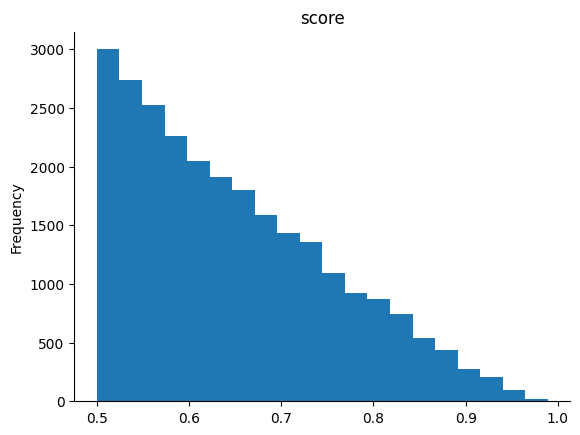

In [ ]:
from matplotlib import pyplot as plt
data['score'].plot(kind='hist', bins=20, title='score')
#data[data['score'] > 0.5]['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
temp = data[data['score'] > 0.9]

In [ ]:
data['name'] = data['name'].apply(lambda x: x.split('/')[4])
data['name']

0         1237661970104451250.jpeg
1         1237656494576828689.jpeg
2         1237671992951374090.jpeg
3         1237671992412078287.jpeg
4         1237661465456673094.jpeg
                    ...           
312979    1237668292833640795.jpeg
312980    1237664132094951427.jpeg
312981    1237665373867409601.jpeg
312982    1237660963479748892.jpeg
312983    1237659329782087736.jpeg
Name: name, Length: 312984, dtype: object

In [ ]:
data[data['score'] > 0.9].to_csv('more_than_0.9.csv')

In [ ]:
data[data['score'] > 0.9].reset_index().drop('index', axis=1).drop('Unnamed: 0', axis=1).to_csv('more_than_0.9.csv')